In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [24]:
from ema_workbench import load_results

In [25]:
path = '../results/'
file_name = '2000_scen__AGGD_reps__0612__with_clusters'
file_ext  = '.tar.gz'

In [26]:
sns.set_style('whitegrid')

### Co-Occurrence Analysis

In [27]:
results = load_results(path + file_name + file_ext)
experiments, outcomes = results
experiments.head(3)

,debt_sales_ratio,wage_sensitivity_prod,init_markup,capital_firm_cap_out_ratio,min_unempl_emigration,migration_unempl_bounds_diff,deu_discount_factor,flood_timing,scenario,policy,...,Cluster (CI_95(Household Population)),Cluster (CI_5(Household Population)),Cluster (MEAN(GDP)),Cluster (VAR(GDP)),Cluster (CI_95(GDP)),Cluster (CI_5(GDP)),Cluster (MEAN(Gini Coefficient)),Cluster (VAR(Gini Coefficient)),Cluster (CI_95(Gini Coefficient)),Cluster (CI_5(Gini Coefficient))
0,3.974297,0.712775,0.099379,0.297524,0.040977,0.136866,0.956540,33.0,0,NaN,...,0,0,0,0,0,2,0,1,0,1
1,4.388648,0.624767,0.069494,0.246466,0.031566,0.160825,0.857878,76.0,1,NaN,...,0,2,0,0,0,0,0,0,1,1
2,3.970944,0.929448,0.489306,0.339357,0.051214,0.166170,0.954534,34.0,2,NaN,...,1,0,3,1,1,1,1,1,0,0


In [46]:
# cluster_vars = [col for col in experiments if col[:7] == 'Cluster']
cluster_vars = [col for col in experiments if col[:12] == 'Cluster (VAR']
cluster_vars.extend([col for col in experiments if col[:12] == 'Cluster (MEA'])
cluster_vars

['Cluster (VAR(Household Population))',
 'Cluster (VAR(GDP))',
 'Cluster (VAR(Gini Coefficient))',
 'Cluster (MEAN(Household Population))',
 'Cluster (MEAN(GDP))',
 'Cluster (MEAN(Gini Coefficient))']

In [47]:
clusters_df = experiments[cluster_vars]
clusters_df = clusters_df.astype('int32')
clusters_df.head(3)

,Cluster (VAR(Household Population)),Cluster (VAR(GDP)),Cluster (VAR(Gini Coefficient)),Cluster (MEAN(Household Population)),Cluster (MEAN(GDP)),Cluster (MEAN(Gini Coefficient))
0,1,0,1,0,0,0
1,1,0,0,1,0,0
2,1,1,1,2,3,1


#### Cluster Counts

Assumes same # of clusters for each cluster type -- consider restructuring this.

In [48]:
cluster_counts_df = pd.DataFrame()
for var in cluster_vars:
    cluster_counts_df[var] = clusters_df[var].value_counts()
cluster_counts_df.index.names = ['Cluster']
cluster_counts_df.sort_index(inplace=True)

cluster_counts_df

,Cluster (VAR(Household Population)),Cluster (VAR(GDP)),Cluster (VAR(Gini Coefficient)),Cluster (MEAN(Household Population)),Cluster (MEAN(GDP)),Cluster (MEAN(Gini Coefficient))
Cluster,,,,,,
0,428,832,315,420,648,371
1,1572,1168,1685,285,131,1118


#### Generate Co-Occurrence Matrices 

For now, as a separate matrix per outcome pair.

In [69]:
cooccurrence_mtxs = {}
for x in cluster_vars:
    for y in cluster_vars:
        # Skip same-comparisons and cases already added
        if x == y:
            continue
        if (y, x) in cooccurrence_mtxs:
            continue

        # For stochastic outcomes, only pair same-metric or same-outcome
        metrics = {}
        out_names = {}
        for var in [x, y]:
            name = var.strip('Cluster (')[:-1]
            metrics[var] = name.split('(')[0]
            out_names[var] = name.split('(')[1][:-1] # Cut off trailing bracket

        if metrics[x] != metrics[y] and out_names[x] != out_names[y]:
            continue

        # Create the matrix
        dim_x = clusters_df[x].max() + 1
        dim_y = clusters_df[y].max() + 1
        mtx = pd.DataFrame(np.zeros((dim_x,dim_y), dtype=np.int32))

        # Fill the matrix
        counts = clusters_df.value_counts(subset=[x, y])
        for idx, row in counts.items():
            mtx.iloc[idx] = int(row)

        mtx.index.names = [x]
        mtx.columns.names = [y]

        cooccurrence_mtxs[(x, y)] = mtx


In [70]:
[pair for pair in cooccurrence_mtxs]

[('Cluster (VAR(Household Population))', 'Cluster (VAR(GDP))'),
 ('Cluster (VAR(Household Population))', 'Cluster (VAR(Gini Coefficient))'),
 ('Cluster (VAR(Household Population))',
  'Cluster (MEAN(Household Population))'),
 ('Cluster (VAR(GDP))', 'Cluster (VAR(Gini Coefficient))'),
 ('Cluster (VAR(GDP))', 'Cluster (MEAN(GDP))'),
 ('Cluster (VAR(Gini Coefficient))', 'Cluster (MEAN(Gini Coefficient))'),
 ('Cluster (MEAN(Household Population))', 'Cluster (MEAN(GDP))'),
 ('Cluster (MEAN(Household Population))', 'Cluster (MEAN(Gini Coefficient))'),
 ('Cluster (MEAN(GDP))', 'Cluster (MEAN(Gini Coefficient))')]

In [71]:
cooccurrence_mtxs[cluster_vars[0], cluster_vars[1]]

Cluster (VAR(GDP)),0,1
Cluster (VAR(Household Population)),,
0,427,1
1,405,1167


In [72]:
# clusters_df[clusters_df['Cluster (Household Population)'] == 2]

#### Plot Co-Occurrence Matrices as Heatmaps

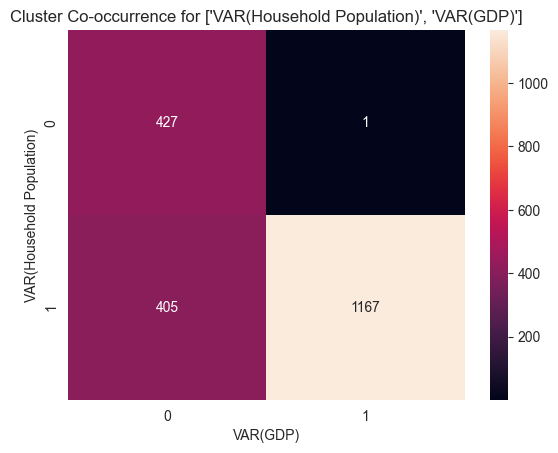

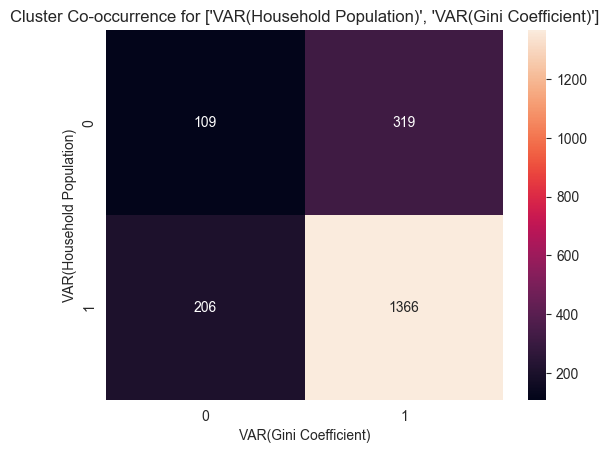

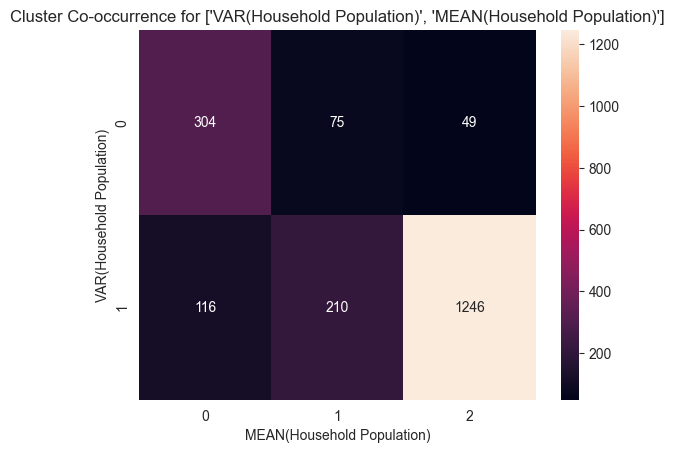

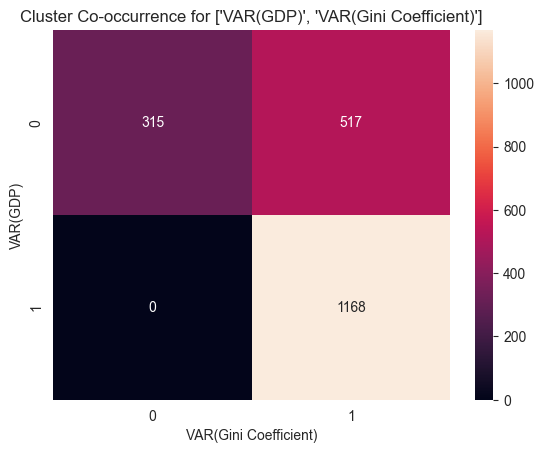

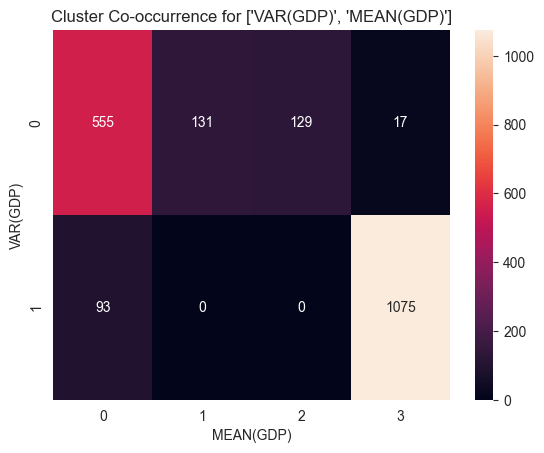

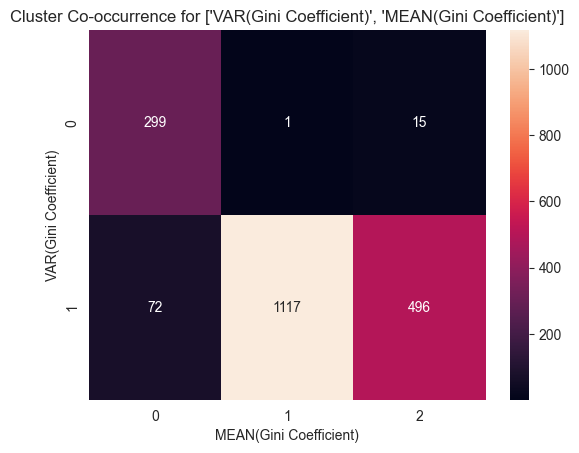

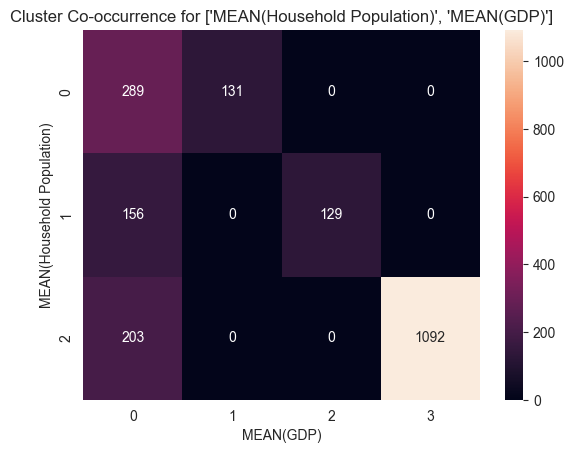

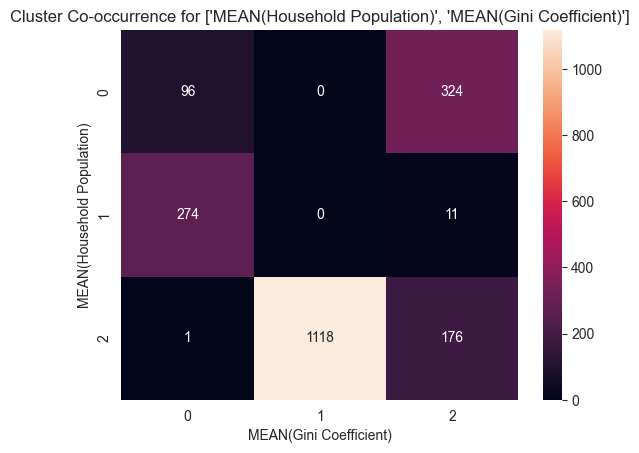

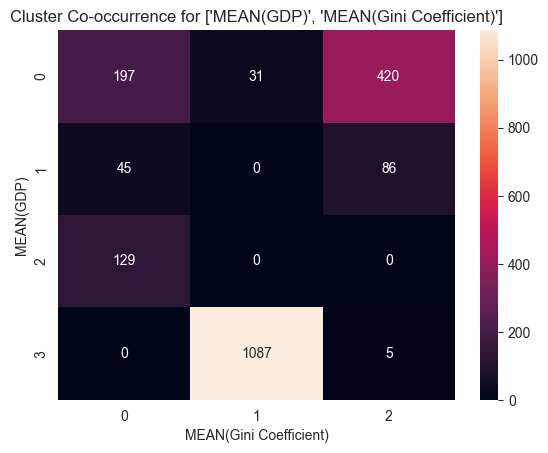

In [73]:
for pair, mtx in cooccurrence_mtxs.items():
    sns.heatmap(mtx.values, annot=True, fmt="d")

    # pair_names = [var.split('(')[-1][:-1] for var in pair] # for normal output vars
    pair_names = [var.strip('Cluster (')[:-1] for var in pair] # for stochastic description vars
    plt.title(f'Cluster Co-occurrence for {pair_names}')
    plt.xlabel(pair_names[1])
    plt.ylabel(pair_names[0])
    plt.show()

#### Plot a full, nested heatmap of cluster co-occurrence

In [74]:
# Building a heatmap using pivot tables
data = experiments.copy()
data['count'] = data['model'] == 'CRAB'
data['count'].head(3)

0    True
1    True
2    True
Name: count, dtype: bool

In [75]:
n_vars = len(cluster_vars) // 2
rows = cluster_vars[:n_vars]
cols = cluster_vars[n_vars:]

rows, cols

(['Cluster (VAR(Household Population))',
  'Cluster (VAR(GDP))',
  'Cluster (VAR(Gini Coefficient))'],
 ['Cluster (MEAN(Household Population))',
  'Cluster (MEAN(GDP))',
  'Cluster (MEAN(Gini Coefficient))'])

In [76]:
pvt = pd.pivot_table(data, values='count', index=rows, columns=cols, aggfunc='sum')
pvt

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_11096\539537826.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pvt = pd.pivot_table(data, values='count', index=rows, columns=cols, aggfunc='sum')


Cluster (MEAN(Household Population))                                                     0  \
Cluster (MEAN(GDP))                                                                      0   
Cluster (MEAN(Gini Coefficient))                                                         0   
Cluster (VAR(Household Population)) Cluster (VAR(GDP)) Cluster (VAR(Gini Coefficient))       
0                                   0                  0                                28   
                                                       1                                19   
                                    1                  0                                 0   
                                                       1                                 0   
1                                   0                  0                                 2   
                                                       1                                 2   
                                    1                  0                                 0   
                                                       1                                 0   

Cluster (MEAN(Household Population))                                                       \
Cluster (MEAN(GDP))                                                                         
Cluster (MEAN(Gini Coefficient))                                                        1   
Cluster (VAR(Household Population)) Cluster (VAR(GDP)) Cluster (VAR(Gini Coefficient))      
0                                   0                  0                                0   
                                                       1                                0   
                                    1                  0                                0   
                                                       1                                0   
1                                   0                  0                                0   
                                                       1                                0   
                                    1                  0                                0   
                                                       1                                0   

Cluster (MEAN(Household Population))                                                         \
Cluster (MEAN(GDP))                                                                           
Cluster (MEAN(Gini Coefficient))                                                          2   
Cluster (VAR(Household Population)) Cluster (VAR(GDP)) Cluster (VAR(Gini Coefficient))        
0                                   0                  0                                  5   
                                                       1                                126   
                                    1                  0                                  0   
                                                       1                                  1   
1                                   0                  0                                  1   
                                                       1                                 97   
                                    1                  0                                  0   
                                                       1                                  8   

Cluster (MEAN(Household Population))                                                        \
Cluster (MEAN(GDP))                                                                      1   
Cluster (MEAN(Gini Coefficient))                                                         0   
Cluster (VAR(Household Population)) Cluster (VAR(GDP)) Cluster (VAR(Gini Coefficient))       
0                                   0                  0                                 9   
                                                       1                                36   
                                    1            

TODO: Return to fixing this! I gave up on getting the graphs to look right but I think it's possible.

In [77]:
# def dim_ratios(axis, figsize):
#     """Get the proportions of the figure taken up by each axes

#     adapted from seaborn
#     """
#     figdim = figsize[axis]
#     # Get resizing proportion of this figure for the dendrogram and
#     # colorbar, so only the heatmap gets bigger but the dendrogram stays
#     # the same size.
#     dendrogram = min(2.0 / figdim, 0.2)

#     # add the colorbar
#     colorbar_width = 0.8 * dendrogram
#     colorbar_height = 0.2 * dendrogram
#     if axis == 0:
#         ratios = [colorbar_width, colorbar_height]
#     else:
#         ratios = [colorbar_height, colorbar_width]

#     # Add the ratio for the heatmap itself
#     ratios += [0.8]

#     return ratios

In [78]:
# def plot_line(ax, axis, i, lw, length):
#     """Helper function for plotting lines separating bins in the hierarchical
#     index"""

#     if axis == 0:
#         ax.plot([i, i], [length, 1], lw=lw, color="grey")
#     else:
#         ax.plot([length, 1], [i, i], lw=lw, color="grey")

# def plot_category(ax, axis, i, label, pos, level):
#     """helper function for plotting label"""

#     if axis == 0:
#         rot = "horizontal"
#         if (level > 0) & (len(str(label)) > 4):
#             rot = "vertical"
#         ax.text(i, pos, label, ha="center", va="center", rotation=rot)
#     else:
#         rot = "horizontal"
#         if (level == 0) & (len(str(label)) > 4):
#             rot = "vertical"
#         ax.text(pos, i, label, ha="center", va="center", rotation=rot)


In [79]:

# def plot_index(ax, ax_plot, axis, index, plot_labels=True, plot_cats=True):
#     """helper function for visualizing the hierarchical index

#     Parameters
#     ----------

#     ax : Axes instance
#          the axes on which to plot the hierarchical index
#     ax_plot : Axes instance
#               the axes on which the table itself is displayed
#     axis : int {0, 1}
#            indicates whether we are plotting rows or columns
#     plot_label : bool, optional
#                  if true, also plot names of uncertain factors
#     plot_cats : bool, options
#                 if true, plot category names for uncertain factors

#     """

#     for entry in ["bottom", "top", "right", "left"]:
#         ax.spines["bottom"].set_color("grey")

#     if axis == 0:
#         names = index.names
#         ax.spines["top"].set_color("white")
#         ax.spines["top"].set_linewidth(1.0)
#         ax.spines["bottom"].set_color("white")
#         ax.spines["bottom"].set_linewidth(1.0)

#         ax.invert_yaxis()
#         ax.yaxis.tick_right()
#         ax.set_xticks([])

#         if plot_labels:
#             tick_locs = np.linspace(1 / (2 * len(names)), 1 - 1 / (2 * len(names)), len(names))
#             ax.set_yticks(tick_locs)
#             ax.set_yticklabels(names)
#         else:
#             ax.set_yticks([])
#     else:
#         index = index[::-1]
#         names = index.names
#         ax.set_yticks([])

#         ax.spines["left"].set_color("white")
#         ax.spines["left"].set_linewidth(1.0)
#         ax.spines["right"].set_color("white")
#         ax.spines["right"].set_linewidth(1.0)

#         if plot_labels:
#             tick_locs = np.linspace(1 / (2 * len(names)), 1 - 1 / (2 * len(names)), len(names))
#             ax.set_xticks(tick_locs)
#             ax.set_xticklabels(names, rotation="vertical")
#         else:
#             ax.set_xticks([])

#     try:
#         nr_levels = len(index.levels)
#         levels = index.levels
#         indices = index.values
#     except AttributeError:
#         nr_levels = 1
#         levels = [index.values.tolist()]
#         indices = list(zip(index.values))

#     if axis == 1:
#         indices = indices[::-1]

#     last = indices[0]

#     plot_line(ax, axis, 0, 1, 0)  # first line
#     plot_line(ax, axis, len(indices), 1, 0)  # last line

#     offsets = {}
#     for i, level in enumerate(levels):
#         offset = 1
#         for entry in levels[0:i]:
#             offset *= len(entry)

#         offset *= len(level)
#         offset = 1 / (offset * 2)

#         offsets[i] = offset

#     if plot_cats:
#         for p in range(0, nr_levels):
#             pos = 1 / (2 * nr_levels) + p / (nr_levels)
#             plot_category(ax, axis, 0 + offsets[p] * len(index), last[p], pos, p)

#     for i, entry in enumerate(indices[1::]):
#         i += 1
#         comparison = map(lambda a, b: a == b, entry, last)

#         for j, item in enumerate(comparison):
#             if not item:
#                 ratio = j / nr_levels
#                 lw = 1 * (1 - ratio)
#                 length = ratio
#                 break

#         last = entry

#         plot_line(ax, axis, i, lw, length)

#         if plot_cats:
#             # add values
#             for p in range(j, nr_levels):
#                 pos = 1 / (2 * nr_levels) + p / (nr_levels)
#                 plot_category(ax, axis, i + offsets[p] * len(index), entry[p], pos, p)
#         if axis:
#             ax_plot.axhline(i, c="w", lw=lw)
#         else:
#             ax_plot.axvline(i, c="w", lw=lw)


In [80]:
# with sns.axes_style("white"):
#     figsize = (10,10)
#     fig = plt.figure(figsize=figsize)
#     width_ratios = dim_ratios(figsize=figsize, axis=1)
#     height_ratios = dim_ratios(figsize=figsize, axis=0)
#     gs = mpl.gridspec.GridSpec(
#         3, 3, wspace=0.01, hspace=0.01, width_ratios=width_ratios, height_ratios=height_ratios,
#     )

#     ax_plot = fig.add_subplot(gs[2, 2])
#     ax_rows = fig.add_subplot(gs[2, 0:2], facecolor="white")
#     ax_cols = fig.add_subplot(gs[0:2, 2], facecolor="white")
#     cax = fig.add_subplot(gs[0, 0])
#     sns.heatmap(pvt.values, ax=ax_plot, cbar_ax=cax, cmap="viridis", vmin=0, vmax=np.nanmax(pvt.values))

#     # set the tick labels
#     ax_plot.set_xticks([])
#     ax_plot.set_yticks([])

#     # plot row labeling
#     ax_rows.set_ylim(ax_plot.get_ylim())
#     ax_rows.set_xlim(0, 1)
#     plot_index(
#         ax_rows,
#         ax_plot,
#         axis=1,
#         index=pvt.index,
#         plot_labels=True,
#         plot_cats=True, 
#     )

#     # plot column labeling
#     ax_cols.set_xlim(ax_plot.get_xlim())
#     ax_cols.set_ylim(0, 1)
#     plot_index(
#         ax_cols,
#         ax_plot,
#         axis=0,
#         index=pvt.columns,
#         plot_labels=True,
#         plot_cats=True,
#     )